# Book Recommendation System - Part 1

by: [Ulya Azmah Khairiah](https://www.linkedin.com/in/ulyazmah/)

## Background

According to a survey conducted by Pew Research in 2019, the popularity of digital books is anticipated to rise over the coming years. The sales of e-book readers increases along with the popularity of e-books. Amazon is one of the largest providers of e-books in the world through its product, Kindle. Assuming that Amazon (who now owns Goodreads, the largest book related social networking site) will integrate Goodreads and Kindle into a new ecosystem, a high-quality recommendation system will become ever more important to increase the usage of the new ecosystem. By improving the process of product identification and recommendation, the recommendation system enables businesses to drastically enhance conversion rates. A recommendation system will help both Amazon and readers in the commercial environment. Amazon can benefit from increased Kindle book sales, while readers can find the best books that suit their taste.

In addition, we also need to promote reading as a good habit for people. Based on the book "Atomic Habits" by James Clear, to build good habits, we need to make the process of doing habits as easy as possible. To get used to reading, we must make the book selection process easier. One thing we can do is create a recommendation system.

## Problem Statement

In this project, I tried to make a book recommendation system based on data from the Goodreads application. Goodreads is a social networking site that specializes in cataloging books. Goodreads was established with the goal of igniting interest in reading. The key to encouraging individuals to read is assisting them in selecting books they will enjoy and then enabling them to discuss their impressions and experiences with others.


**Goal**: <br>
Design book recommendation system by several methods and explore the strengths and weaknesses of each method.

**Research Question**: 
1. How can we calculate the similarity between books based on their content? How can we apply it to a recommendation system?
2. How can we predict the rating that a user will give to books that they haven't read? How can we apply it to a recommendation system?
3. What are the strengths and weakness of each method? How to overcome tht weakness?

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

## Import Dataset

In [2]:
pd.options.display.float_format = '{:.2f}'.format
r = pd.read_csv('data/ratings.csv')
b = pd.read_csv('data/books_enriched.csv')

Here we use 2 data, which consists of rating and the other one consists of book metadata.

## Data Understanding

### 1. Rating

In [3]:
r.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In **dataset r**, there are three columns, which are:
1. `user_id`: user identification number
2. `book_id`: book identification number
3. `rating`: rating given by `user_id`

In [4]:
r.shape

(5976479, 3)

In [5]:
for col in r.columns:
    print(f"Number of {col} is {r[col].nunique()}")

Number of user_id is 53424
Number of book_id is 10000
Number of rating is 5


There are 5,976,479 ratings given by 53,424 people on 10,000 books.

### 2. Books

In [6]:
b.head(3).T

,0,1,2
Unnamed: 0,0,1,2
index,0,1,2
authors,['Suzanne Collins'],"['J.K. Rowling', 'Mary GrandPré']",['Stephenie Meyer']
average_rating,4.34,4.44,3.57
best_book_id,2767052,3,41865
book_id,1,2,3
books_count,272,491,226
description,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,Harry Potter's life is miserable. His parents ...,About three things I was absolutely positive.\...
genres,"['young-adult', 'fiction', 'fantasy', 'science...","['fantasy', 'fiction', 'young-adult', 'classics']","['young-adult', 'fantasy', 'romance', 'fiction..."
goodreads_book_id,2767052,3,41865


In [7]:
b.shape

(10000, 30)

In this dataset, there are 30 columns. However, after investigating them, there are several columns that are repeated. For example too many book_id columns, 2 title columns, 2 authors column, details of the number of reviews per rating for each book, etc. In order to make cleaner metadata, I will do data preprocessing.

**Columns in dataset b**:<br>
- Identification number related (`book_id`, `goodreads_book_id`, `best_book_id`, `work_id`, `isbn`, `isbn13`)
- Title related (`original_title`, `title`)
- Authors related (`authors`, `authors_2`)
- Publication year related (`original_publication_year`, `publishDate`: the publication date)
- Rating related (`average_rating`, `ratings_count`: number of review, `work_ratings_count`, `work_text_reviews_count`, `ratings_1`, `ratings_2`, `ratings_3`, `ratings_4`, `ratings_5`)
- Image Url (`image_url`, `small_image_url`)
- `books_count`: number of edition available
- `language_code`: abbreviated language tags for all books
- `genres`: the genre tags taken from the top shelves users have assigned to a book. Only the main Goodreads genres have been retained
- `pages`: the total page count
- `description`: a free text summarizing the book's content
- Others (`Unnamed: 0`, `index`)

In [8]:
#divide the columns to numerical and categorical value
nums = b.select_dtypes(include=[np.number]).columns
cats = b.select_dtypes(exclude=[np.number]).columns

In [9]:
b[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,10000.00,4999.50,2886.90,0.00,2499.75,4999.50,7499.25,9999.00
index,10000.00,4526.32,2567.92,0.00,2351.75,4567.50,6661.25,9999.00
average_rating,10000.00,4.00,0.25,2.47,3.85,4.02,4.18,4.82
best_book_id,10000.00,5471213.58,7827329.89,1.00,47911.75,425123.50,9636112.50,35534230.00
book_id,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
books_count,10000.00,75.71,170.47,1.00,23.00,40.00,67.00,3455.00
goodreads_book_id,10000.00,5264696.51,7575461.86,1.00,46275.75,394965.50,9382225.25,33288638.00
isbn13,9415.00,9755044298883.40,442861920665.57,195170342.00,9780316192995.00,9780451528640.00,9780830777175.00,9790007672390.00
original_publication_year,9979.00,1981.99,152.58,-1750.00,1990.00,2004.00,2011.00,2017.00
pages,9927.00,359.42,216.95,0.00,250.00,336.00,424.00,5216.00


- There are many unique columns: `Unnamed: 0`, `index`, `best_book_id`, `book_id`, `goodreads_book_id`, `isbn13`, `work_id`. The column `book_id` will be used to merge to rating table, so the other columns will be dropped.

- The oldest book was written in -1750 which means 1750 BC.
- Mean of `average_rating` is 4.002 (pretty good!)
- We found weird number of pages (0), we found that book should have at least 80 pages to be published
- The most popular book has 4,780,653 reviews, the least popular has 2,716 reviews.

In [10]:
b[cats].describe().T

,count,unique,top,freq
authors,10000,5057,['Stephen King'],58
description,9943,9772,The first in a spectacularly genre-mashing adv...,4
genres,10000,4351,"['fantasy', 'fiction']",152
image_url,10000,6669,https://s.gr-assets.com/assets/nophoto/book/11...,3332
isbn,9300,9300,439023483,1
language_code,10000,41,eng,9680
original_title,9415,9274,,5
publishDate,9992,4679,"(None, None, None)",75
small_image_url,10000,6669,https://s.gr-assets.com/assets/nophoto/book/50...,3332
title,10000,9964,Selected Poems,4


- The most popular author is Stephen King
- Selected Poems appears 4 times. Is it the same book?
- Because we already has `original_publication_year`, `publishDate` will be dropped
- `authors`, `genres`, `publishDate`, and `authors_2` has unnecessary characters

Now, let's select numerical columns that are not unique value columns.

In [11]:
not_unique_nums = ['average_rating', 'books_count', 'original_publication_year', 'pages', 
                    'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'ratings_count', 
                    'work_ratings_count', 'work_text_reviews_count']

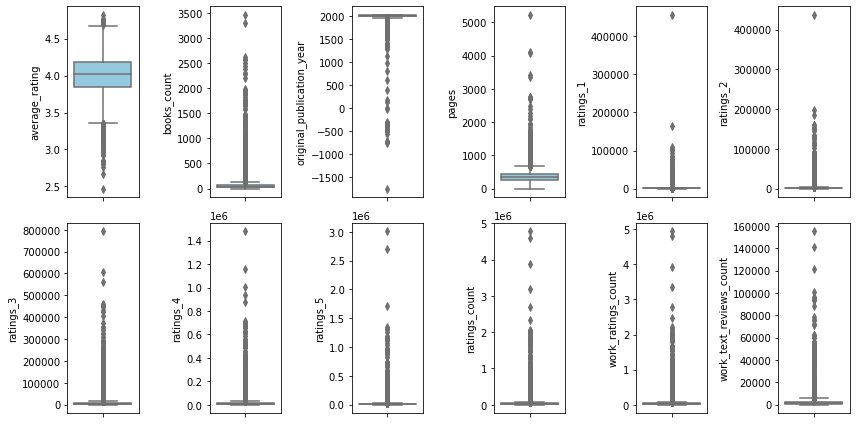

In [12]:
# adjust the figure size for better readability
plt.figure(figsize=(12,6))

# plotting
features = not_unique_nums
for i in range(0, len(features)):
    plt.subplot(2, 6, i+1)
    sns.boxplot(y=b[features[i]], color='skyblue')
    plt.tight_layout()

The data varies greatly, so there is no need to clean the outliers. Now, let's check the correlation between columns.

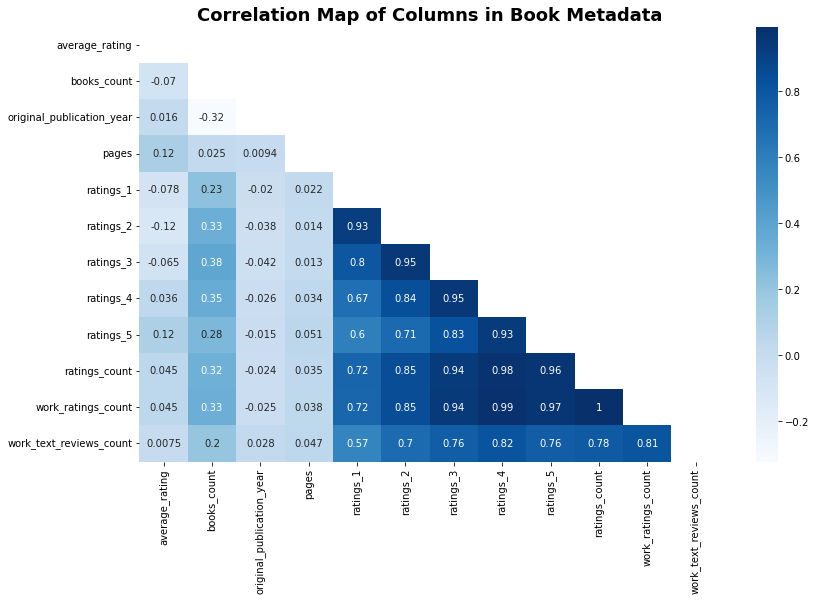

In [13]:
#build correlation table
corr = b[not_unique_nums].corr()

# create heatmap
upper_triangle = np.triu(corr)
plt.figure(figsize=(13,8))
sns.heatmap(corr, cmap="Blues", annot=True, mask=upper_triangle)
plt.title('Correlation Map of Columns in Book Metadata', weight='bold', fontsize=18)
plt.show()

- There is multicollinearity between ratings related columns. We can also see that the higher ratings show higher correlation to `work_ratings_count` and `work_text_reviews_count`. People tend to leave reviews for books they like. I will only use `ratings_count`.
- There is a high correlation between `original_publication_year` and `books_count`. It makes sense since the older book probably has been printed more and translated to many languages.

## Data Preprocessing

### Missing Value and Duplicated Rows

In [14]:
#check missing value
dataset = [r, b]
for data in dataset:
    print(data.isnull().values.any())

False
True


In [15]:
#check duplicated rows
for data in dataset:
    print(data.duplicated().values.any())

False
False


There is no duplicate row in both dataset, but we have missing value in book metadata.

In [16]:
#make a copy 
books = b.copy()

In [17]:
percent_missing = books.isnull().sum() * 100 / len(books)
missing_value = (pd.DataFrame({'percent_missing': percent_missing})).sort_values(by=['percent_missing'], ascending=False)
missing_value[missing_value['percent_missing']>0]

,percent_missing
isbn,7.00
original_title,5.85
isbn13,5.85
pages,0.73
description,0.57
original_publication_year,0.21
publishDate,0.08


- Impute `original_publication_year` by using `publishDate`, then drop `publishDate`. I chose `original_publication_year` because it has the same format meanwhile `publishDate` has various data styles.
- Impute `pages` with median.
- Impute `description` with book's title
- Drop `isbn`, `original_title`, `isbn13`, there is no need to impute these columns.

In [18]:
#compare original_publication_year and publishdate when original_publication_year is null
books[books['original_publication_year'].isnull()][['original_publication_year', 'publishDate']]

,original_publication_year,publishDate
198,NaN,October 28th 2008
3249,NaN,February 7th 2006
3881,NaN,September 29th 2009
4252,NaN,November 10th 2010
4303,NaN,June 23rd 2009
4392,NaN,April 8th 2013
5001,NaN,November 9th 2004
5208,NaN,December 6th 2010
5648,NaN,October 11th 2006
7163,NaN,November 25th 2004


Lucky that all rows that are invalid in `original_publication_year` has the year in `publishDate`. Therefore, we can get year in `publishDate` and impute it to `original_publication_year`.

In [19]:
#get year from publishDate to original_publication_year
books['publishDate'].replace(r"[(')]", "", regex=True, inplace=True)
books['publishDate'] = books['publishDate'].str.extract('(\d{4})$').fillna('')
books['original_publication_year'] = books['original_publication_year'].fillna(books['publishDate'])
books['description'] = books['description'].fillna(books['title'])

In [20]:
#impute null in pages with median
books['pages'] = books['pages'].fillna(books['pages'].median())

In [21]:
#drop unnecessary columns with null
books = books.drop(['isbn', 'original_title', 'isbn13', 'publishDate'], axis=1)

In [22]:
#check missing value
books.isnull().values.any()

False

Now we have no missing value anymore!

### Feature Engineering

In [23]:
#keep important columns, drop the rest
cols_to_keep = ['book_id', 'title', 'authors', 'original_publication_year', 'pages', 'description', 'genres', 'average_rating', 'ratings_count', 'books_count']
books = books[cols_to_keep]

Now, let's check the value in each columns. In order to find any strange characters, we need to display column width to maximum. 

In [24]:
#display max column
with pd.option_context('display.max_colwidth', None):
    display(books.head(5))

,book_id,title,authors,original_publication_year,pages,description,genres,average_rating,ratings_count,books_count
0,1,"The Hunger Games (The Hunger Games, #1)",['Suzanne Collins'],2008.00,374.00,"WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love.","['young-adult', 'fiction', 'fantasy', 'science-fiction', 'romance']",4.34,4780653,272
1,2,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)","['J.K. Rowling', 'Mary GrandPré']",1997.00,309.00,"Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is the best of his life, not everything is perfect. There is a dangerous secret object hidden within the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil hands. But doing so will bring him into contact with forces more terrifying than he ever could have imagined.Full of sympathetic characters, wildly imaginative situations, and countless exciting details, the first installment in the series assembles an unforgettable magical world and sets the stage for many high-stakes adventures to come.","['fantasy', 'fiction', 'young-adult', 'classics']",4.44,4602479,491
2,3,"Twilight (Twilight, #1)",['Stephenie Meyer'],2005.00,501.00,"About three things I was absolutely positive.\n\nFirst, Edward was a vampire.\n\nSecond, there was a part of him—and I didn't know how dominant that part might be—that thirsted for my blood.\n\nAnd third, I was unconditionally and irrevocably in love with him.\n\nDeeply seductive and extraordinarily suspenseful, Twilight is a love story with bite.","['young-adult', 'fantasy', 'romance', 'fiction', 'paranormal']",3.57,3866839,226
3,4,To Kill a Mockingbird,['Harper Lee'],1960.00,324.00,"The unforgettable novel of a childhood in a sleepy Southern town and the crisis of conscience that rocked it, To Kill A Mockingbird became both an instant bestseller and a critical success when it was first published in 1960. It went on to win the Pulitzer Prize in 1961 and was later made into an Academy Award-winning film, also a classic.Compassionate, dramatic, and deeply moving, To Kill A Mockingbird takes readers to the roots of human behavior - to innocence and experience, kindness and cruelty, love and hatred, humor and pathos. Now with over 18 million copies in print and translated into forty languages, this regional story by a young Alabama woman claims universal appeal. Harper Lee always considered her book to be a simple love story. Today it is regarded as a masterpiece of American l

In our top 5 entry, we found unnecessary characters that are not supposed to be in `description` column. We need to delete that unnecessary characters in order to make better result in finding similar books. It is actually time consuming to check it one by one, but we tried our best to capture all unnecessary characters and try to guess the rest. And then we delete that unnecessary characters and make all fonts lowercase.

In [25]:
#delete unnecessary characters from authors, genres and description column
col_trans = ['authors', 'genres', 'description']
for col in col_trans:
    books[col].replace(r"[\[\]\-\\\/\"—'()|:]", "", regex=True, inplace=True) 
books['description'].replace({"\n" : " ", "isbn13" : "", "isbn" : "", r"[0-9]{8,}" : "", r"[.,]" : ""}, regex=True, inplace=True)
books['description'] = books['description'].str.lower()

In [26]:
#rename column and change year, pages, and book_count to integer
books.rename(columns = {'original_publication_year':'year'}, inplace = True)
books[['year', 'pages', 'books_count']] = books[['year', 'pages', 'books_count']].astype(int)

We try to check 10 samples. If they are looking good (there are no unnecessary characters anymore) then we are good to go!

In [27]:
with pd.option_context('display.max_colwidth', None):
    display(books.sample(10))

,book_id,title,authors,year,pages,description,genres,average_rating,ratings_count,books_count
8783,5657,I'm Just Here for the Food: Food + Heat = Cooking,Alton Brown,2002,336,blending humor wisdom history pop culture science and basic cooking knowledge the host of food networks good eats presents a special edition of his innovative instructional cooking guide that features various cooking techniques accompanied by a master recipe for each technique and provides a vast array of foodrelated tips and advice,"cookbooks, nonfiction, science, philosophy, fiction",4.21,15870,7
9308,7856,"What Remains: A Memoir of Fate, Friendship, and Love",Kevin Henkes,2005,32,wemberly worried about everything big things little things and things in between then it was time for school to start and wemberly worried even more if you ever worry or know someone who does this is the book for youwemberly worried about spilling her juice about shrinking in the bathtub even about snakes in the radiator she worried morning noon and night worry worry worry her family said too much worryand wemberly worried about one thing most of all her first day of school but when its time to go back to school and she meets a fellow worrywart in her class wemberly realizes that school is too much fun to waste time worrying!this warm and comforting backtoschool favorite is from kevin henkes the nationally bestselling and celebrated creator of lillys purple plastic purse kittens first full moon and chrysanthemum“this winning heroine speaks to the worrywart in everyone” publishers weekly starred review,"fiction, fantasy",4.16,9602,16
1443,1536,"Blood of the Fold (Sword of Truth, #3)",Terry Goodkind,1996,623,there is an alternate cover edition hererichard comes to terms with his true identity as a war wizard the new world and all the freedom of humankind is under threat from the imperial order after he had brought down the barrier between the old and new world the imperial order has already sent delegations and armies into the new world richards only option to stop the invasion is to claim his heritage and unite all free kingdoms and provinces under one rule and one command,"fantasy, fiction, romance",3.98,60624,57
7191,8512,Battlefield Earth: A Saga of the Year 3000,L. Ron Hubbard,1982,1050,suspense thrills action and adventure earth has been dominated for 1000 years by an alien invaderand man is an endangered species from the handful of surviving humans a courageous leader emergesjonnie goodboy tyler who challenges the invincible might of the alien psychlo empire in a battle of epic scale danger and intrigue with the fate of the earth and of the universe in the tenuous balance,"sciencefiction, fiction, fantasy, classics",3.49,11671,55
8404,3304,Freckle Juice,Judy Blume,1978,40,nicky has freckles they cover his face his ears and the whole back of his neck sitting behind him in class andrew once counted eightysix of them and that was just a start! if andrew had freckles like nicky his mother would never know if his neck was dirtyone day after school andrew works up enough courage to ask nicky where he got his freckles when knowitall sharon overhears she offers andrew her secret freckle juice recipe for fifty cents its a lot of money but andrew is desperate at home he carefully mixes the strange combination of ingredients then the unexpected happens,"fiction, youngadult, classics, contemporary, books",3.82,34579,36
4132,4562,"Darkest Mercy (Wicked Lovely, #5)",Melissa Marr,2011,327,send the messengers for the faery courts this is the end the summer king is missing; the dark court is bleeding; and a stranger walks the streets of huntsdale his presence signifying the deaths of powerful feyaislinn tends to the summer court searching for her absent king and yearning for seth torn between his new queen and his old love keenan works from afar to strengthen his court against the coming war donia longs for fiery passion even as she coolly readies the winter court for battle and seth swor

# EDA Questions

### 1. How is the distribution of the rating for the book?

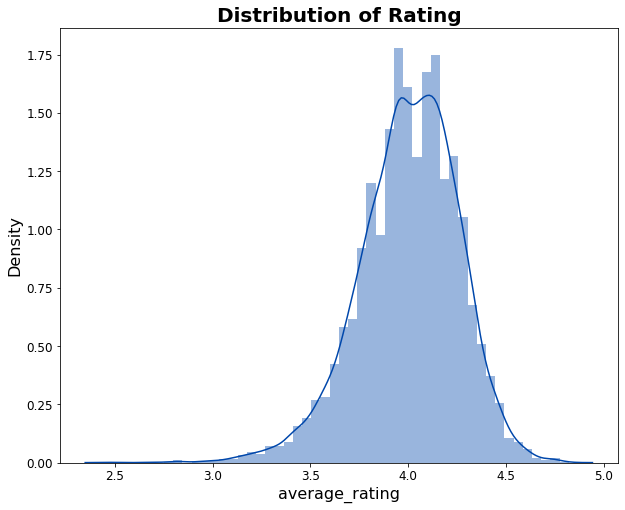

In [28]:
#Rating distribution based on books metadata
plt.figure(figsize=(10,8))
sns.distplot(books['average_rating'], color = '#0047AB')
plt.title('Distribution of Rating', weight='bold', fontsize =20)
plt.xlabel('average_rating', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [29]:
books.describe()

,book_id,year,pages,average_rating,ratings_count,books_count
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,1982.04,359.25,4.00,54001.24,75.71
std,2886.90,152.42,216.17,0.25,157369.96,170.47
min,1.00,-1750.00,0.00,2.47,2716.00,1.00
25%,2500.75,1990.00,251.00,3.85,13568.75,23.00
50%,5000.50,2004.00,336.00,4.02,21155.50,40.00
75%,7500.25,2011.00,422.00,4.18,41053.50,67.00
max,10000.00,2017.00,5216.00,4.82,4780653.00,3455.00


Since this is a list of 10,000 popular books, we admit the fact that the majority of the books are good books with an average value of 4. 

### 2. How is the distribution of the average rating per user?

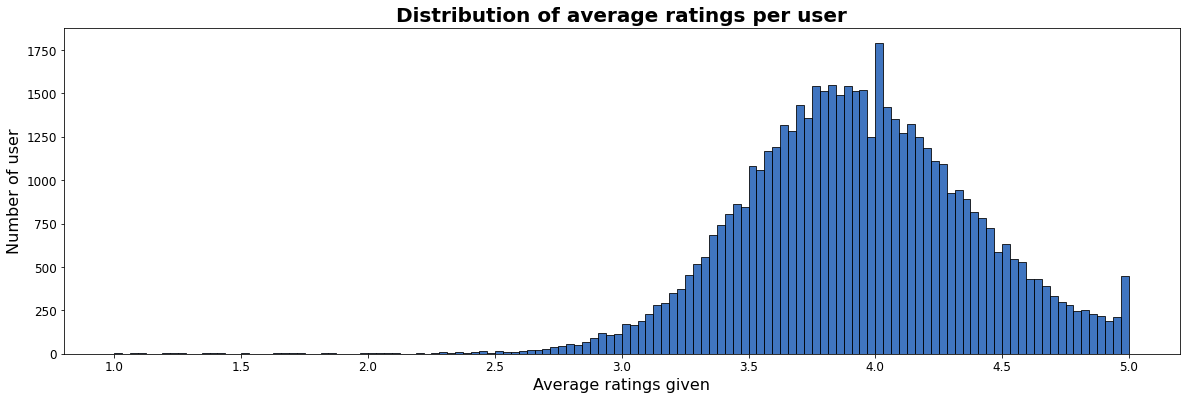

In [30]:
#Rating distribution based on rating dataset

# average rating per user
av_rating_user = r.groupby('user_id')['rating'].mean().reset_index()

#jumlah rating per buku
plt.figure(figsize=(20,6))
sns.histplot(data=av_rating_user, x='rating', color='#0047AB')
plt.title('Distribution of average ratings per user', weight='bold', fontsize=20)
plt.xlabel('Average ratings given', fontsize=16)
plt.ylabel('Number of user', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

There are few low ratings, and the peak seems to be at 4.

### 3. How many ratings does a book usually get?

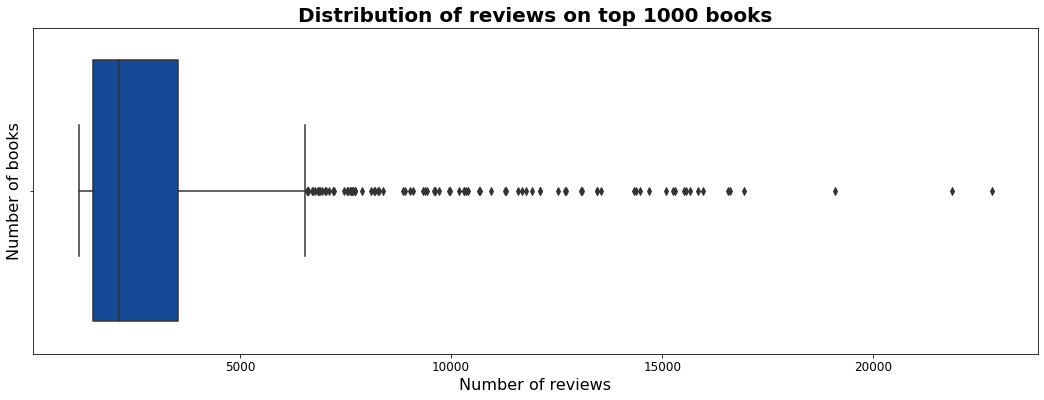

In [31]:
# ratings per book
ratings_per_book = (r.groupby('book_id')['rating'].count().reset_index()).sort_values(by='rating', ascending=False)

#visualize
plt.figure(figsize=(18,6))
sns.boxplot(data=ratings_per_book.head(1000), x='rating', color = '#0047AB')
plt.title('Distribution of reviews on top 1000 books', weight='bold', fontsize=20)
plt.xlabel('Number of reviews', fontsize=16)
plt.ylabel('Number of books', fontsize=16)
plt.xticks(fontsize=12)
plt.show()

The distribution of reviews on books is positively skewed. There are more books that has less ratings. Let's check the number of rating distribution.

In [32]:
ratings_per_book['rating'].describe()

count   10000.00
mean      597.65
std      1267.29
min         8.00
25%       155.00
50%       248.00
75%       503.00
max     22806.00
Name: rating, dtype: float64

Books in this database have at least 8 reviews, while popular books have 22,806 reviews. The gap is too large. Now, let's check the outliers.

In [33]:
q3, q1 = np.percentile(ratings_per_book, [75 ,25])
iqr = q3 - q1
maximum = q3 + (1.5 * iqr)
outlier_books = len(ratings_per_book[ratings_per_book['rating'] > maximum])
print(f'We have {outlier_books} books that are considered outlier, because they have more than {int(maximum)} number of ratings')

We have 26 books that are considered outlier, because they have more than 12515 number of ratings


### 4. How many ratings does a user usually give?

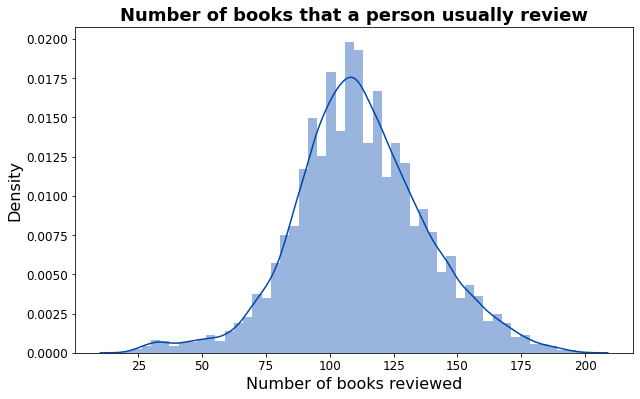

In [34]:
#agregate ratings by user
book_per_user = r.groupby('user_id')['rating'].count().reset_index()

#visualize
plt.figure(figsize=(10,6))
sns.distplot(book_per_user['rating'], color='#0047AB')
plt.title('Number of books that a person usually review', weight='bold', fontsize=18)
plt.xlabel('Number of books reviewed', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [35]:
book_per_user['rating'].describe()

count   53424.00
mean      111.87
std        26.07
min        19.00
25%        96.00
50%       111.00
75%       128.00
max       200.00
Name: rating, dtype: float64

At most people review 200 books and at least 19 books. The average person gives a review of 111 books.
From 10,000 books in our dataset, even the **user with the highest number of reviews** managed to give a rating to **only 2% of all of the books**. Data in user is very sparse, so it will be better to use item-based collaborative filtering.

I also checked which user has the most reviews. I will use their `user_id` to test the recommendations.

In [36]:
book_per_user[book_per_user['rating'] == book_per_user['rating'].max()]['user_id'].values

array([12874, 30944])

We will check the book recommended for one of this user later.

### 5. Does the number of reviews affect ratings?

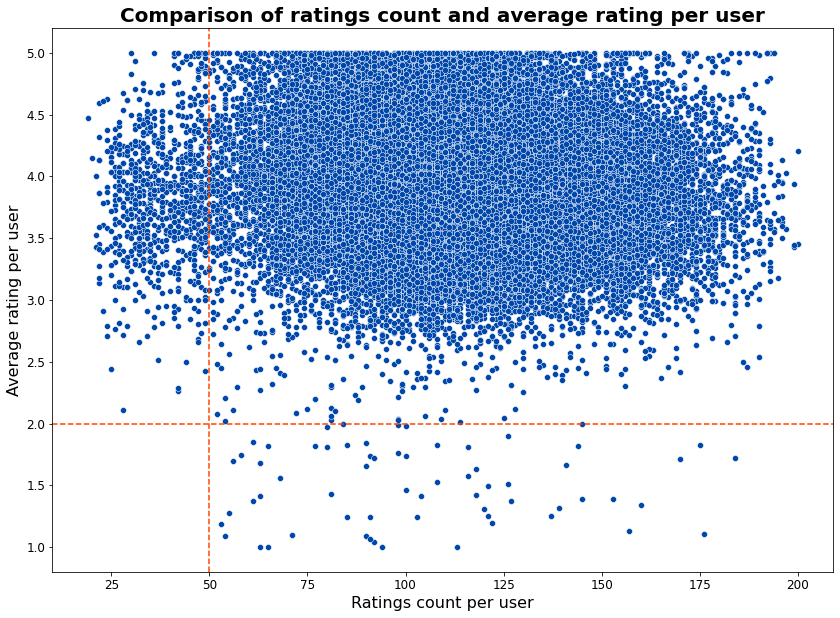

In [37]:
# merge average rating and number of ratings for each sampeld individual
id_merged = av_rating_user.merge(book_per_user, left_on="user_id", right_on="user_id")

#visualize
plt.figure(figsize=(14,10))
sns.scatterplot(x=id_merged['rating_y'], y=id_merged['rating_x'], color='#0047AB')
plt.title('Comparison of ratings count and average rating per user', weight='bold', fontsize=20)
plt.xlabel('Ratings count per user', fontsize=16)
plt.ylabel('Average rating per user', fontsize=16)
plt.axhline(y = 2, color = 'orangered', linestyle = '--')
plt.axvline(x = 50, color = 'orangered', linestyle = '--')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- People who rate < 50 books tend to give higher ratings. 
- People start to give lower rating if they read more books. 
- This could be a result of an inappropriate book recommendation system, so that people end up reading books they don't like.

### 6. Which book has the highest rating and which book has the most ratings?

In [38]:
#Books with highest ratings
book_sorted_ratings = books.sort_values('average_rating', ascending=False)
book_sorted_ratings.head(10)

,book_id,title,authors,year,pages,description,genres,average_rating,ratings_count,books_count
3353,3628,The Complete Calvin and Hobbes,Bill Watterson,2005,1456,box set book one book two book three c...,"comics, graphicnovels, fiction, classics",4.82,28900,14
3043,3275,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",2003,2690,box set containing harry potter and the sorcer...,"fantasy, youngadult, fiction, classics",4.77,33220,11
810,862,"Words of Radiance (The Stormlight Archive, #2)",Brandon Sanderson,2014,1087,words of radiance book two of the stormlight a...,"fantasy, fiction",4.77,73572,34
6779,7947,ESV Study Bible,"Anonymous, Lane T. Dennis, Wayne A. Grudem",2002,2750,the esv study bible was designed to help you u...,"christian, nonfiction, religion, classics, his...",4.76,8953,96
7403,8854,Mark of the Lion Trilogy,Francine Rivers,1993,1468,this bestselling trilogy chronicles a tale of ...,"christian, historicalfiction, fiction, romance...",4.76,9081,6
4068,4483,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,1996,176,when cartoonist bill watterson announced that ...,"comics, graphicnovels, fiction",4.75,22351,21
387,422,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,1998,4100,over 4000 pages of harry potter and his world ...,"fantasy, youngadult, fiction, classics",4.74,190050,76
5593,6361,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,1996,176,in the world that calvin and his stuffed tiger...,"comics, fiction, graphicnovels",4.74,16766,22
5767,6590,The Authoritative Calvin and Hobbes: A Calvin ...,Bill Watterson,1990,254,a collection of calvin and hobbes cartoons the...,"comics, graphicnovels, fiction, classics",4.73,16087,21
3457,3753,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,2005,3342,six years of magic adventure and mystery make ...,"fantasy, fiction, youngadult, classics",4.73,24618,6


In [39]:
#(Books with most reviews)
book_sorted_ratings_count = books.sort_values('ratings_count', ascending=False)
book_sorted_ratings_count.head(10)

,book_id,title,authors,year,pages,description,genres,average_rating,ratings_count,books_count
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008,374,winning means fame and fortunelosing means cer...,"youngadult, fiction, fantasy, sciencefiction, ...",4.34,4780653,272
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",1997,309,harry potters life is miserable his parents ar...,"fantasy, fiction, youngadult, classics",4.44,4602479,491
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,2005,501,about three things i was absolutely positive ...,"youngadult, fantasy, romance, fiction, paranormal",3.57,3866839,226
3,4,To Kill a Mockingbird,Harper Lee,1960,324,the unforgettable novel of a childhood in a sl...,"classics, fiction, historicalfiction, youngadult",4.25,3198671,487
4,5,The Great Gatsby,F. Scott Fitzgerald,1925,200,alternate cover edition isbn isbn13 the great...,"classics, fiction, historicalfiction, romance",3.89,2683664,1356
5,6,The Fault in Our Stars,John Green,2012,313,despite the tumorshrinking medical miracle tha...,"youngadult, romance, fiction, contemporary",4.26,2346404,226
6,7,The Hobbit,J.R.R. Tolkien,1937,366,in a hole in the ground there lived a hobbit n...,"fantasy, classics, fiction, youngadult",4.25,2071616,969
7,8,The Catcher in the Rye,J.D. Salinger,1951,277,the heronarrator of the catcher in the rye is ...,"classics, fiction, youngadult",3.79,2044241,360
9,10,Pride and Prejudice,Jane Austen,1813,279,alternate cover edition of isbn since its imme...,"classics, fiction, romance, historicalfiction",4.24,2035490,3455
8,9,"Angels & Demons (Robert Langdon, #1)",Dan Brown,2000,736,worldrenowned harvard symbologist robert langd...,"fiction, mystery, thriller, suspense, crime, h...",3.85,2001311,311


- When we sort book based on `ratings_count`, we found several books that have an `average_rating` lower than the mean (less than 4.002)
- When we sort book based on `average_rating`, we found several books lower number of reviews (`ratings_count`).
- Therefore we should make a new score calculation that also takes into account the `average_rating` and `ratings_count`.

### 7. How is the relationship between the number of ratings and the average rating?

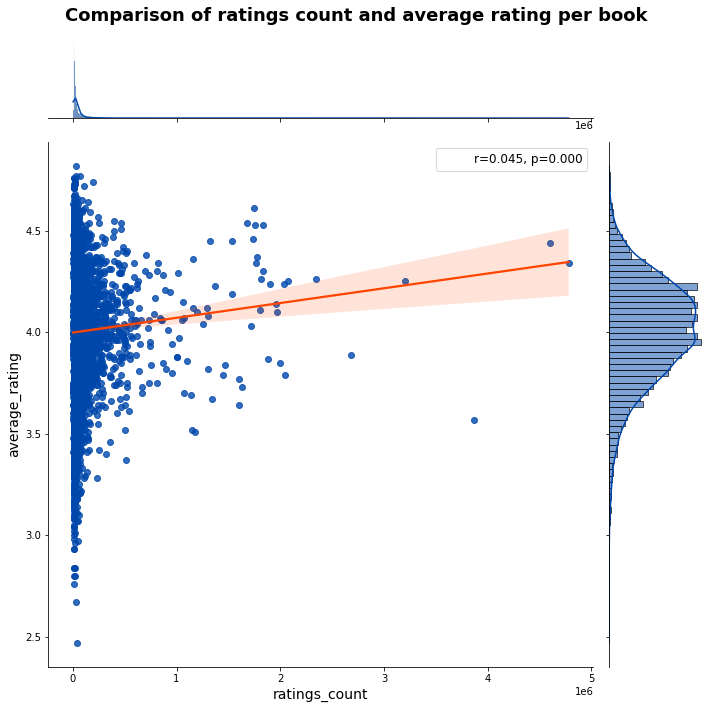

In [40]:
x= books['ratings_count']
y = books['average_rating']

j = sns.jointplot(x, y, 
                  height=10, 
                  kind='reg',
                  color='#0047AB',
                  line_kws={'color':'orangered'})

r, p = stats.pearsonr(x, y)

phantom, = j.ax_joint.plot([], [], linestyle="", alpha=0)
j.ax_joint.legend([phantom],['r={:.3f}, p={:.3f}'.format(r,p)], fontsize=12)

j.fig.suptitle('Comparison of ratings count and average rating per book', weight='bold', fontsize=18)
j.set_axis_labels('ratings_count', 'average_rating', fontsize=14)

# labels appear outside of plot area, so auto-adjust
j.figure.tight_layout() 

plt.show()

A book that is popular (has lots of ratings) is more likely to get a good rating. However, if we look at our data, the correlation between `average_rating` and `ratings_count` is not too big, which means that many popular books have low ratings.

### 8. Who is the author with most books?

In [41]:
#First try with the simple count
author_book_count = books.groupby('authors')['title'].count().sort_values(ascending = False)
author_book_count.head()

authors
Stephen King       60
Nora Roberts       59
Dean Koontz        46
Terry Pratchett    42
Agatha Christie    39
Name: title, dtype: int64

Based in simple count, author with most books is Stephen King. However, in fact there are books written by more than one author, right?. So let's check them.

In [42]:
#take 'Stephen King' as an example
auth = []
books.authors.apply(lambda x: auth.append(x) if 'Stephen King' in x else [])
auth[:5]

['Stephen King',
 'Stephen King, Bernie Wrightson',
 'Stephen King',
 'Stephen King',
 'Stephen King']

Actually, there are several books written by more than one authors. These books are not included in the total books written by the author! I decided to pick only the first author to simplify our process.

In [43]:
prev_count = books.authors.value_counts()['Stephen King']
print(f'Number of books written by Stephen King was {len(auth)} not {prev_count}.')

Number of books written by Stephen King was 97 not 60.


In [44]:
#split authors in each books
a = []
books.authors.apply(lambda x: a.append(x) if ',' in x else [])
a[:5]

['J.K. Rowling, Mary GrandPré',
 'Anne Frank, Eleanor Roosevelt, B.M. MooyaartDoubleday',
 'Stieg Larsson, Reg Keeland',
 'J.K. Rowling, Mary GrandPré, Rufus Beck',
 'J.K. Rowling, Mary GrandPré']

In [45]:
#insert splitted author list in every row
authors_list = books['authors'].apply(lambda x: [a for a in x.split(', ')] if ',' in x else x)
authors_list.head()

0                  Suzanne Collins
1    [J.K. Rowling, Mary GrandPré]
2                  Stephenie Meyer
3                       Harper Lee
4              F. Scott Fitzgerald
Name: authors, dtype: object

In [46]:
splitted_authors = authors_list.apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True)
splitted_authors.name = 'authors'
splitted_authors.head()

0    Suzanne Collins
1       J.K. Rowling
1      Mary GrandPré
2    Stephenie Meyer
3         Harper Lee
Name: authors, dtype: object

In [47]:
#remove previous author column and join the new splitted authors
books = books.drop('authors', axis=1).join(splitted_authors)

In [48]:
# Take the first author for each book and remove the rest
books = books.drop_duplicates(subset='book_id', keep='first')

In [49]:
#author with most books
book_count_real = books['authors'].value_counts()
book_count_real.head()

James Patterson    96
Stephen King       80
Nora Roberts       63
Dean Koontz        51
Terry Pratchett    48
Name: authors, dtype: int64

Now, instead of Stephen King, we found James Patterson is actually the author with the most books!

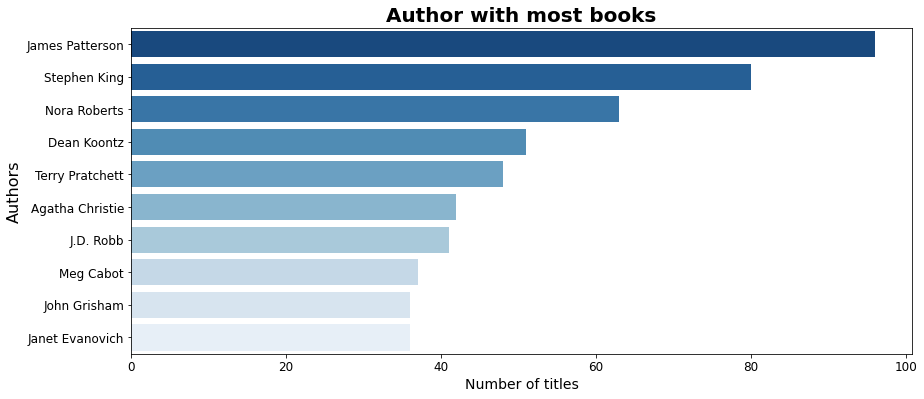

In [50]:
#visualize
plt.figure(figsize=(14,6))
sns.barplot(x=book_count_real.head(10).values, 
            y=book_count_real.head(10).index,
           palette = 'Blues_r')
plt.title('Author with most books', weight='bold', fontsize=20)
plt.xlabel('Number of titles', fontsize=14)
plt.ylabel('Authors', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### 9. Who is the most popular author?

In [51]:
# Let's check authors with most ratings_count
popular_author = books.groupby('authors')['ratings_count'].sum().sort_values(ascending = False)
popular_author.head(5)

authors
J.K. Rowling       16036005
Suzanne Collins     8646393
Stephenie Meyer     8512437
Stephen King        8250167
J.R.R. Tolkien      5454844
Name: ratings_count, dtype: int64

### 10. Who is the author that has good ratings book?

In [52]:
# Let's check authors with biggest number of rates (total number for all books)
high_rating_author = books.groupby('authors')['average_rating'].mean().sort_values(ascending = False)
high_rating_author.head(5)

authors
Bill Watterson     4.70
Hafez              4.63
James E. Talmage   4.63
Eiichiro Oda       4.63
Angie Thomas       4.62
Name: average_rating, dtype: float64

### 11. How is the relationship between the number of pages and the year the book was published?

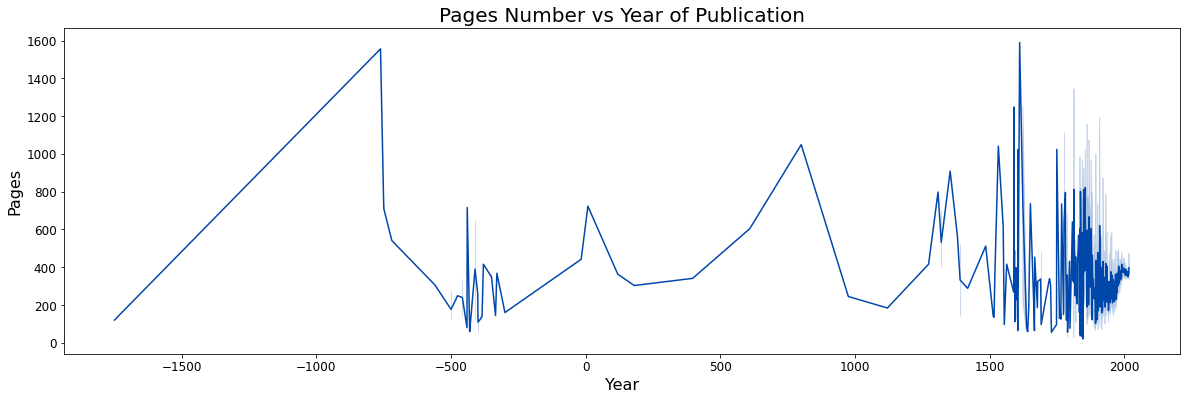

In [53]:
plt.figure(figsize = (20,6))
sns.lineplot(x = 'year', y = 'pages', data = books, color='#0047AB')
plt.title('Pages Number vs Year of Publication', fontsize =20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Pages', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The range of year of publication is too large, therefore we need to check when the entry is more dense.

In [54]:
# Check the trend for books published after 1800
books_after_1800 = books[books['year'] > 1800]

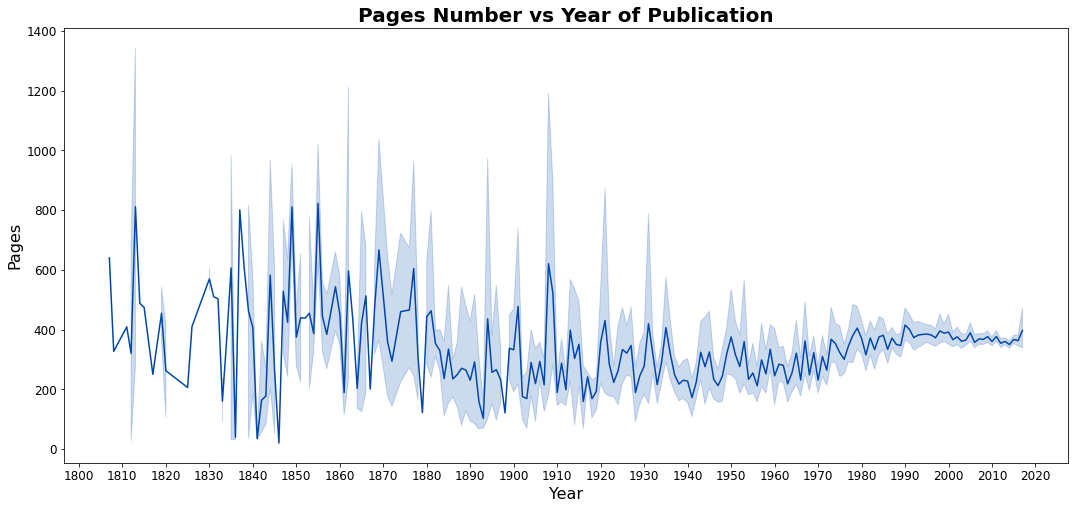

In [55]:
plt.figure(figsize = (18,8))
sns.lineplot(x = 'year', y = 'pages', data = books_after_1800, color='#0047AB')
plt.title('Pages Number vs Year of Publication', weight='bold', fontsize =20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Pages', fontsize=16)
plt.xticks(np.arange(1800, 2021, 10), fontsize=12)
plt.yticks(np.arange(0, 1401, 200), fontsize=12)
plt.show()

- Before 1900, the number of pages was randomly distributed. There are books that have more than 1000 pages but also books that have less than 100 pages. We can see that after 1900 the distribution started to stable, but it is less than 500 pages. 
- After 1980, the trend also show slight increase. Most of recent books have around 400 pages.

### 12. What genre dominates the dataset?

In [56]:
#split authors in each books
g = []
books.genres.apply(lambda x: g.append(x) if ',' in x else [])
g[:5]

['youngadult, fiction, fantasy, sciencefiction, romance',
 'fantasy, fiction, youngadult, classics',
 'youngadult, fantasy, romance, fiction, paranormal',
 'classics, fiction, historicalfiction, youngadult',
 'classics, fiction, historicalfiction, romance']

In [57]:
#insert splitted author list in every row
genres_list = books['genres'].apply(lambda x: [g for g in x.split(', ')] if ',' in x else x)
genres_list.head()

0    [youngadult, fiction, fantasy, sciencefiction,...
1             [fantasy, fiction, youngadult, classics]
2    [youngadult, fantasy, romance, fiction, parano...
3    [classics, fiction, historicalfiction, youngad...
4      [classics, fiction, historicalfiction, romance]
Name: genres, dtype: object

In [58]:
splitted_genres = genres_list.apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True)
splitted_genres.name = 'genres'
splitted_genres.head()

0        youngadult
0           fiction
0           fantasy
0    sciencefiction
0           romance
Name: genres, dtype: object

In [59]:
#remove previous author column and join the new splitted authors
book_genres = books.drop('genres', axis=1).join(splitted_genres)

In [60]:
x = book_genres['genres']
y = book_genres['average_rating']

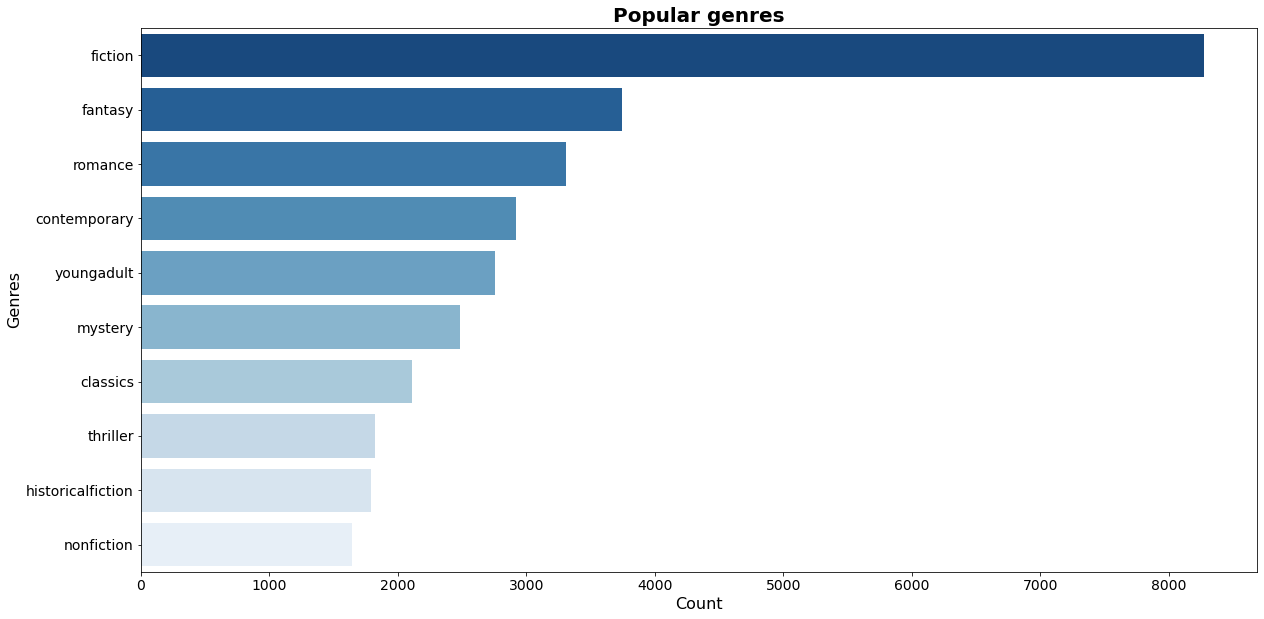

In [61]:
#rank the genre based on number of books
genres_rank = book_genres.genres.value_counts()

#visualize
plt.figure(figsize=(20,10))
sns.barplot(x=genres_rank.head(10).values,
            y=genres_rank.head(10).index,
            palette = 'Blues_r')
plt.title('Popular genres', weight='bold', fontsize=20)
plt.xlabel('Count', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Export Data

After making some changes to the data, we can now save our clean data and use it in the book recommendation system.

In [62]:
books.to_csv('data/books_cleaned.csv')